# **Desafio Cientista de Dados**

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediram para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.
Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.

## Dicionário dos dados do dataset usado

A base de dados de treinamento contém 16 colunas. Seus nomes são
auto-explicativos, mas, caso haja alguma dúvida, a descrição das colunas é:

* id – Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo
* nome - Representa o nome do anúncio
* host_id - Representa o id do usuário que hospedou o anúncio
* host_name – Contém o nome do usuário que hospedou o anúncio
* bairro_group - Contém o nome do bairro onde o anúncio está localizado
* bairro - Contém o nome da área onde o anúncio está localizado
* latitude - Contém a latitude do local
* longitude - Contém a longitude do local
* room_type – Contém o tipo de espaço de cada anúncio
* price - Contém o preço por noite em dólares listado pelo anfitrião
* minimo_noites - Contém o número mínimo de noites que o usuário deve reservar
* numero_de_reviews - Contém o número de comentários dados a cada listagem
* ultima_review - Contém a data da última revisão dada à listagem
* reviews_por_mes - Contém o número de avaliações fornecidas por mês
* calculado_host_listings_count - Contém a quantidade de listagem por host
* disponibilidade_365 - Contém o número de dias em que o anúncio está disponível para reserva

## Importações das bibliotecas usadas

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from lightgbm import LGBMRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
import lightgbm
import matplotlib
print("Versão do Python:", sys.version)
print("Versão do Pandas:", pd.__version__)
print("Versão do Numpy:", np.__version__)
print("Versão do Matplotlib:", matplotlib.__version__)
print("Versão do Seaborn:", sns.__version__)
print("Versão do NLTK:", nltk.__version__)
print("Versão do scikit-learn:", sklearn_version)
print("Versão do Joblib:", joblib.__version__)
print("Versão do LightGBM:", lightgbm.__version__)

Versão do Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Versão do Pandas: 2.2.2
Versão do Numpy: 1.26.4
Versão do Matplotlib: 3.10.0
Versão do Seaborn: 0.13.2
Versão do NLTK: 3.9.1
Versão do scikit-learn: 1.6.1
Versão do Joblib: 1.4.2
Versão do LightGBM: 4.5.0


## Preparação dos dados

In [3]:
# Carregando o dataset
data_path = "teste_indicium_precificacao.csv"
data = pd.read_csv(data_path)

In [4]:
data.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
# Tipos de cada variável
data.dtypes

,0
id,int64
nome,object
host_id,int64
host_name,object
bairro_group,object
bairro,object
latitude,float64
longitude,float64
room_type,object
price,int64


In [6]:
# Quantidade de instâncias/linhas e variáveis/colunas
linhas, colunas = data.shape
print("Linhas: ", linhas)
print("Colunas: ", colunas)

Linhas:  48894
Colunas:  16


In [7]:
# Para saber quantos valores nulos (ou 0) há em cada variável
data.isna().sum()

,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


In [8]:
# Removendo linhas com valores nulos em nome e host_name
data.dropna(subset=['nome', 'host_name'], inplace=True)

In [9]:
# Convertendo a coluna para datetime
data['ultima_review'] = pd.to_datetime(data['ultima_review'], errors='coerce')

In [10]:
# Preenchendo com a mediana de reviews_por_mes
data['reviews_por_mes'].fillna(data['reviews_por_mes'].median(), inplace=True)

<ipython-input-10-607aa4f0c858>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['reviews_por_mes'].fillna(data['reviews_por_mes'].median(), inplace=True)


In [11]:
# Preenchendo com a média das datas de ultima_review
data_validas = data.dropna(subset=['ultima_review'])
data_media = data_validas['ultima_review'].mean()
data['ultima_review'].fillna(data_media, inplace=True)

<ipython-input-11-2bdbeaaa2be7>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ultima_review'].fillna(data_media, inplace=True)


In [12]:
# Eliminando duplicidade
data.drop_duplicates(inplace=True)

In [13]:
# Transformando em NaN os valores negativos nas variáveis numéricas
variaveis_verificacao = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                          'calculado_host_listings_count', 'disponibilidade_365']

for coluna in variaveis_verificacao:
    # Substituindo valores negativos por NaN
    data.loc[data[coluna] < 0, coluna] = np.nan

# Verificando e corrigindo valores maiores que 365 na variável 'disponibilidade_365'
data.loc[data['disponibilidade_365'] > 365, 'disponibilidade_365'] = np.nan

# Verificação final para mostrar quais valores foram ajustados
print("Valores ajustados nas variáveis:")
print(data[variaveis_verificacao].isnull().sum())

Valores ajustados nas variáveis:
price                            0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64


In [14]:
# Removendo registros com valores de preço considerados outliers
# Mantemos apenas os dados onde o preço é menor ou igual ao percentil 99
limite_superior = data['price'].quantile(0.99)
data = data[data['price'] <= limite_superior]

print(f"Limite de preço aplicado: {limite_superior:.2f}")
print(f"Número de registros restantes: {len(data)}")

Limite de preço aplicado: 799.00
Número de registros restantes: 48383


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48383 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48383 non-null  int64         
 1   nome                           48383 non-null  object        
 2   host_id                        48383 non-null  int64         
 3   host_name                      48383 non-null  object        
 4   bairro_group                   48383 non-null  object        
 5   bairro                         48383 non-null  object        
 6   latitude                       48383 non-null  float64       
 7   longitude                      48383 non-null  float64       
 8   room_type                      48383 non-null  object        
 9   price                          48383 non-null  float64       
 10  minimo_noites                  48383 non-null  float64       
 11  numero_de_reviews   

In [16]:
# Verificando a quantidade de valores zero na coluna 'price'
zero_price_count = (data['price'] == 0).sum()
zero_price_count

11

In [17]:
# Removendo as linhas onde 'price' é 0
df_sem_zero = data[data['price'] != 0]

# Exibindo o número de linhas após a remoção
print("Número de linhas após remover os registros com 'price' igual a 0:", df_sem_zero.shape[0])

Número de linhas após remover os registros com 'price' igual a 0: 48372


In [18]:
data = df_sem_zero
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48372 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48372 non-null  int64         
 1   nome                           48372 non-null  object        
 2   host_id                        48372 non-null  int64         
 3   host_name                      48372 non-null  object        
 4   bairro_group                   48372 non-null  object        
 5   bairro                         48372 non-null  object        
 6   latitude                       48372 non-null  float64       
 7   longitude                      48372 non-null  float64       
 8   room_type                      48372 non-null  object        
 9   price                          48372 non-null  float64       
 10  minimo_noites                  48372 non-null  float64       
 11  numero_de_reviews   

In [19]:
# Verificando a quantidade de valores zero na coluna 'disponibilidade_365'
zero_disponibilidade_count = (data['disponibilidade_365'] == 0).sum()
zero_disponibilidade_count

17387

In [20]:
# Verificando o total de linhas totais restantes
total_rows = data.shape[0]

# Calculando a porcentagem
percentage_zeros = (zero_disponibilidade_count / total_rows) * 100

print(f"Total de linhas: {total_rows}")
print(f"Número de linhas com 'disponibilidade_365' = 0: {zero_disponibilidade_count}")
print(f"Porcentagem: {percentage_zeros:.2f}%")

Total de linhas: 48372
Número de linhas com 'disponibilidade_365' = 0: 17387
Porcentagem: 35.94%


Eliminar simplesmente essas linhas significaria perder cerca de 36% dos dados, o que pode reduzir consideravelmente a quantidade de informações disponíveis para a modelagem. Como perder mais de um terço dos registros pode impactar a robustez e a representatividade do modelo, uma abordagem mais indicada é tratar esses valores como dados faltantes e imputá-los.

Uma estratégia de imputação adequada é substituir os zeros pelo valor mediano dos registros que possuem disponibilidade maior que zero. A mediana é uma medida robusta a outliers e pode representar melhor a “disponibilidade típica” para imóveis que estão efetivamente disponíveis.

In [21]:
# Calculando a mediana da 'disponibilidade_365' considerando apenas valores não zero
median_disponibilidade = data.loc[data['disponibilidade_365'] > 0, 'disponibilidade_365'].median()
print(f"Mediana da 'disponibilidade_365' para valores não zero: {median_disponibilidade}")

# Imputando os zeros com a mediana calculada
data['disponibilidade_365'] = data['disponibilidade_365'].replace(0, median_disponibilidade)

# Verificando se ainda há zeros após a imputação
new_zero_count = (data['disponibilidade_365'] == 0).sum()
print(f"Novo número de linhas com 'disponibilidade_365' = 0: {new_zero_count}")

Mediana da 'disponibilidade_365' para valores não zero: 166.0
Novo número de linhas com 'disponibilidade_365' = 0: 0


<ipython-input-21-8754f84cc15c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disponibilidade_365'] = data['disponibilidade_365'].replace(0, median_disponibilidade)


## Análise exploratória dos dados

In [22]:
# Verificando dados estatísticos das variáveis numéricas
pd.set_option('display.float_format', '{:.3f}'.format)
data.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48372.000,48372.000,48372.000,48372.000,48372.000,48372.000,48372.000,48372,48372.000,48372.000,48372.000
mean,19022720.150,67593339.033,40.729,-73.952,137.583,6.962,23.412,2018-10-04 16:09:21.184115200,1.243,7.184,171.776
min,2595.000,2438.000,40.500,-74.244,10.000,1.000,0.000,2011-03-28 00:00:00,0.010,1.000,1.000
25%,9478326.500,7824646.750,40.690,-73.983,69.000,1.000,1.000,2018-10-04 07:23:14.374033920,0.270,1.000,99.000
50%,19679355.500,30826898.500,40.723,-73.955,105.000,3.000,5.000,2019-01-04 00:00:00,0.720,1.000,166.000
75%,29134712.250,107434423.000,40.763,-73.936,175.000,5.000,24.000,2019-06-19 00:00:00,1.600,2.000,224.000
max,36487245.000,274321313.000,40.913,-73.713,799.000,1250.000,629.000,2019-07-08 00:00:00,58.500,327.000,365.000
std,10974077.090,78568782.513,0.055,0.046,103.793,19.792,44.700,NaN,1.525,33.107,100.949


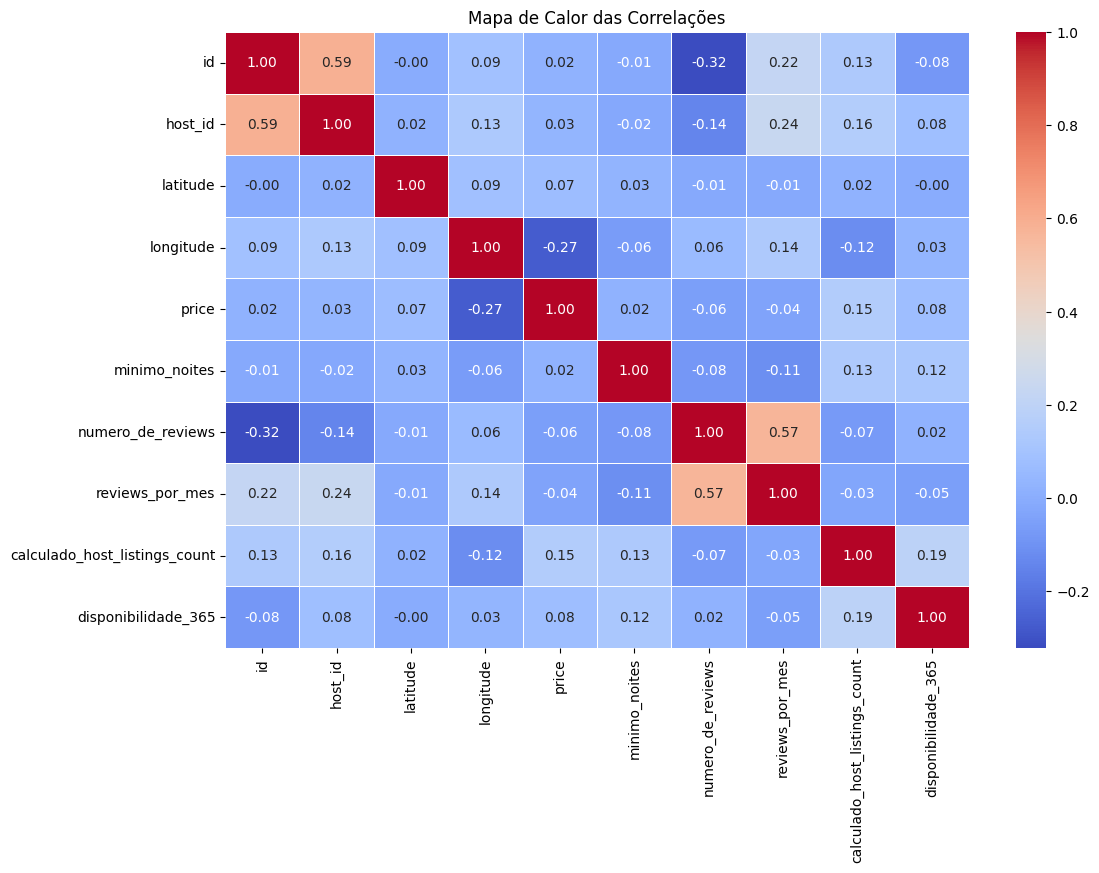

In [23]:
# Filtrando apenas colunas numéricas
numeric_cols = data.select_dtypes(include='number')

# Mapa de calor das correlações
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor das Correlações')
plt.show()

In [24]:
# Tabela de correlações
correlation_table = numeric_cols.corr()
print("Tabela de Correlações (Coeficiente de Pearson):\n", correlation_table)

Tabela de Correlações (Coeficiente de Pearson):
                                   id  host_id  latitude  longitude  price  \
id                             1.000    0.588    -0.003      0.091  0.024   
host_id                        0.588    1.000     0.020      0.129  0.034   
latitude                      -0.003    0.020     1.000      0.085  0.067   
longitude                      0.091    0.129     0.085      1.000 -0.274   
price                          0.024    0.034     0.067     -0.274  1.000   
minimo_noites                 -0.013   -0.018     0.026     -0.065  0.022   
numero_de_reviews             -0.321   -0.141    -0.015      0.058 -0.056   
reviews_por_mes                0.221    0.237    -0.014      0.137 -0.039   
calculado_host_listings_count  0.134    0.156     0.020     -0.116  0.151   
disponibilidade_365           -0.080    0.081    -0.004      0.032  0.076   

                               minimo_noites  numero_de_reviews  \
id                                  

### Coeficiente de Pearson

*   +1: Correlação positiva perfeita (as variáveis crescem juntas).
*   -1: Correlação negativa perfeita (uma cresce e a outra diminui).
*   0: Ausência de correlação linear.

Geralmente:
*   Correlação forte: valores > 0.7 ou < -0.7
*   Correlação moderada: entre 0.5 e 0.7 ou entre -0.5 e -0.7
*   Correlação fraca: entre -0.5 e 0.5

### Interpretação do Mapa de Calor e Tabela de Correlações

* Correlação Positiva Moderada:

reviews_por_mes e numero_de_reviews (coeficiente ≈ 0.57) mostram uma relação esperada, pois mais reviews totais tendem a indicar uma frequência maior de avaliações mensais.

* Correlação Fraca Positiva:

calculado_host_listings_count e disponibilidade_365 (coeficiente ≈ 0.19) indicam que propriedades geridas por hosts com várias listagens estão ligeiramente mais disponíveis durante o ano.

* Correlação Fraca Negativa:

longitude e price (coeficiente ≈ -0.27) sugerem uma leve tendência de preços menores em certas regiões.
A maioria das correlações é fraca, com valores próximos de 0, o que sugere variáveis relativamente independentes.

### Análise de alguns gráficos

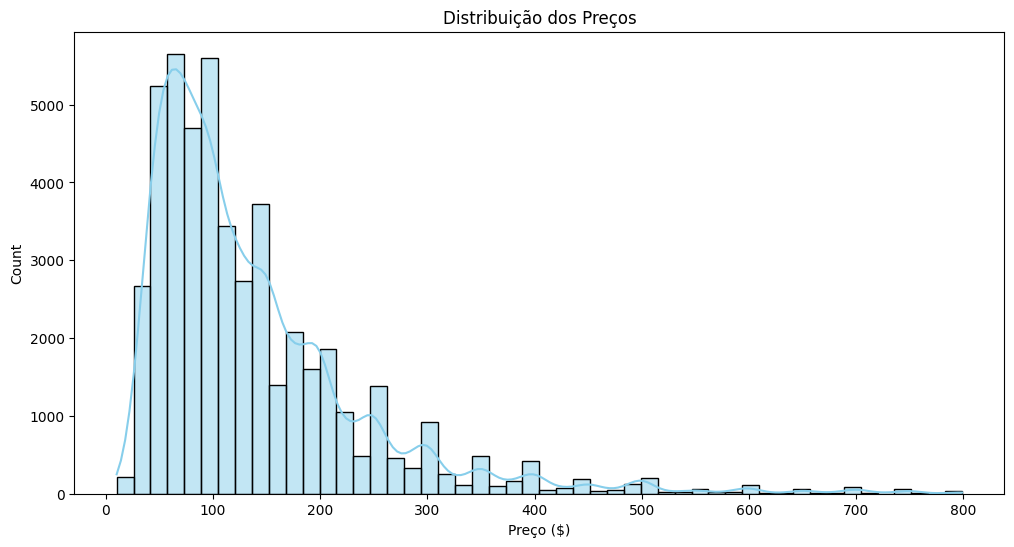

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(data['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição dos Preços')
plt.xlabel('Preço ($)')
plt.show()

Este gráfico representa a distribuição dos preços em um conjunto de dados. A partir da visualização, podemos identificar alguns pontos importantes:

* Assimetria Positiva: A distribuição é fortemente enviesada à direita, indicando que a maioria dos preços está concentrada em valores mais baixos (até cerca de 100 a 200 dólares), enquanto valores mais altos são menos frequentes.

* Moda e Frequência: A maior concentração de preços (modo) parece estar próxima da faixa entre 50 e 100 dólares.

* Outliers: Há uma cauda longa que se estende até valores próximos de 800 dólares. Esses pontos representam preços significativamente mais altos e sugerem a presença de outliers.

* Densidade: A curva KDE sobreposta reforça a ideia de que os preços elevados são eventos raros, enquanto os preços mais acessíveis são muito comuns.

<ipython-input-26-9490b35d393c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='room_type', palette='viridis')


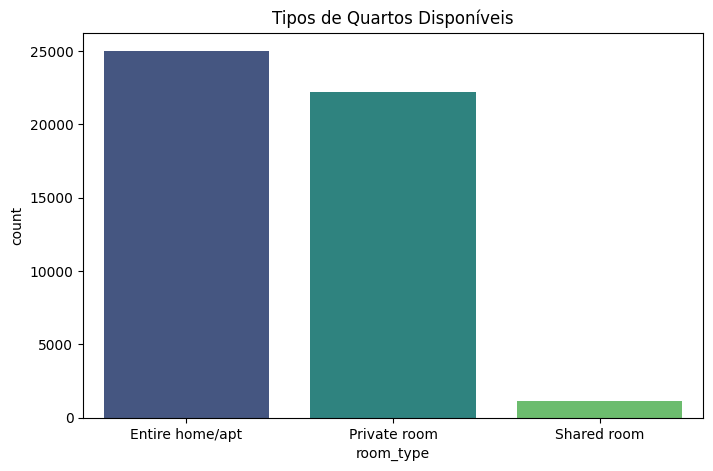

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='room_type', palette='viridis')
plt.title('Tipos de Quartos Disponíveis')
plt.show()

Este gráfico de barras mostra a distribuição dos tipos de quartos disponíveis para aluguel. A partir da análise, destacam-se os seguintes insights:

* Distribuição Predominante: A maioria das ofertas é de imóveis inteiros (categoria Entire home/apt), com cerca de 25.000 registros. Isso indica uma preferência por aluguéis de propriedades completas.

* Quartos Privados: A segunda categoria mais comum é a de Private room, com um número ligeiramente menor do que os imóveis inteiros. Isso sugere uma forte oferta para viajantes que buscam privacidade a um custo potencialmente menor.

* Quartos Compartilhados: A categoria Shared room apresenta uma quantidade insignificante de registros em comparação com as demais. Essa baixa oferta reflete a preferência por opções mais privadas no mercado.

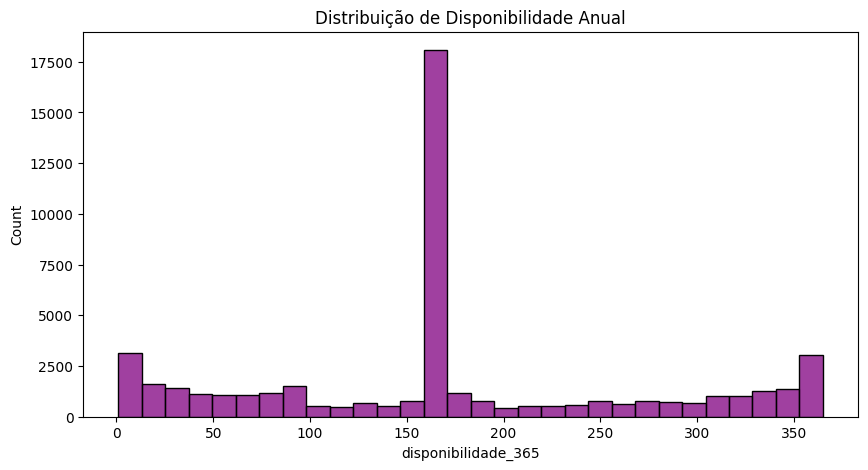

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(data['disponibilidade_365'], kde=False, bins=30, color='purple')
plt.title('Distribuição de Disponibilidade Anual')
plt.show()

Este gráfico representa a distribuição da variável 'disponibilidade_365', que indica a quantidade de dias que um imóvel está disponível para aluguel durante o ano. Vou destacar os pontos principais com base nas observações:

1. Pico Central em torno de 150:

O valor de 150 surge como a mediana utilizada para imputação dos valores que originalmente eram zero. O pico elevado próximo a esse ponto reflete a concentração massiva de registros ajustados pela imputação, criando um artefato visível.

2. Extremos na Direita (355-365):

Há um agrupamento de imóveis com disponibilidade total (próximo de 365 dias), o que é comum para propriedades permanentemente disponíveis para aluguel.

3. Distribuição ao Longo do Eixo:

Fora o pico em 150, a distribuição dos dados é razoavelmente equilibrada, indicando que existem propriedades com diferentes níveis de disponibilidade ao longo do ano.

4. Impacto da Imputação:

Antes do tratamento, a coluna provavelmente teria uma barra extremamente alta na posição zero, já que cerca de 36% dos dados apresentavam valores nulos. Essa imputação preservou os registros e trouxe maior representatividade para o dataset sem perda de dados.

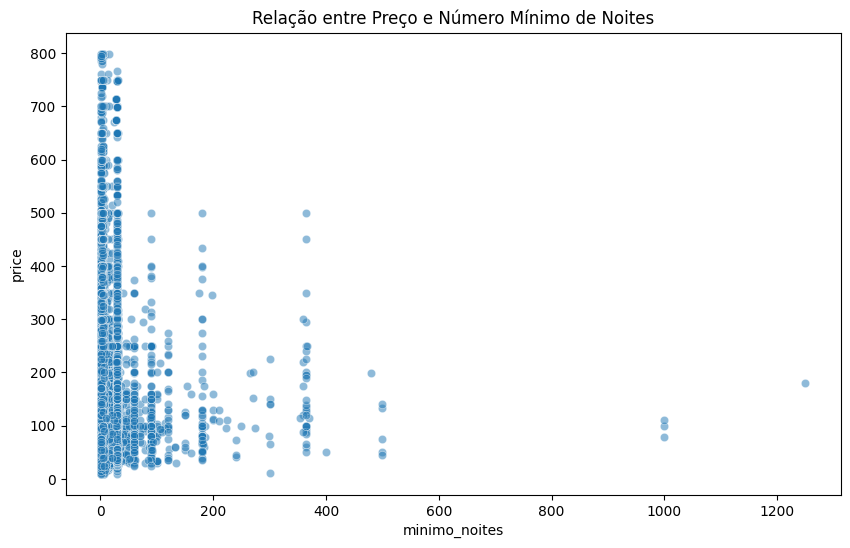

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='minimo_noites', y='price', alpha=0.5)
plt.title('Relação entre Preço e Número Mínimo de Noites')
plt.show()

Este gráfico de dispersão mostra a relação entre o preço e o número mínimo de noites exigidas para aluguel. A seguir estão alguns insights importantes:

* Alta Concentração Próxima ao Eixo:
A maioria dos imóveis possui um mínimo de noites muito baixo (entre 1 e 30 noites) e preços variados, principalmente concentrados abaixo de $200. Isso é um comportamento típico de imóveis que estão disponíveis para estadias curtas.

* Casos Extremos (Outliers):
Existem pontos isolados no gráfico, onde os imóveis exigem um número mínimo muito alto de noites (acima de 400 e até mais de 1.200). Esses são outliers e podem representar imóveis para locações de longo prazo ou com exigências particulares.

* Distribuição Irregular:
Não há uma tendência clara indicando uma correlação forte entre preço e número mínimo de noites. A distribuição parece dispersa, o que sugere que o preço não aumenta proporcionalmente ao aumento do mínimo de noites.

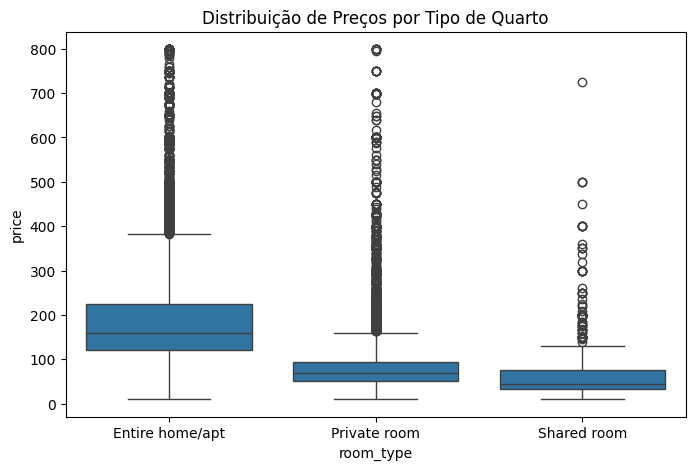

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='room_type', y='price')
plt.title('Distribuição de Preços por Tipo de Quarto')
plt.show()

Este gráfico de boxplot mostra a distribuição dos preços por tipo de quarto. A seguir estão os insights importantes:

* Mediana e Faixa Interquartil:
Para o tipo Entire home/apt, os preços são mais elevados, com uma mediana em torno de \$200.
Quartos do tipo Private room têm uma mediana por volta de \$100.
Shared room apresenta a menor mediana de preços, próxima a $50.

* Variabilidade:
O tipo Entire home/apt apresenta uma maior variação de preços.
Os quartos privados e compartilhados têm distribuições mais concentradas com preços mais baixos.

* Outliers:
Em todos os tipos de quarto, há diversos pontos acima das caixas (outliers), indicando preços muito elevados em comparação com o restante dos dados.
Esses outliers são particularmente visíveis para o tipo Entire home/apt.

* Comparação Geral:
Como esperado, quartos completos têm os preços mais altos, seguidos por quartos privados. Quartos compartilhados tendem a ser os mais econômicos.

### Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

A escolha do melhor bairro para investir em um apartamento para alugar na plataforma pode ser feita a partir de alguns indicadores extraídos do dataset, como:

* Preço Médio do Aluguel: Indica o potencial de receita por diária.
* Taxa de Ocupação: Pode ser aproximada pela diferença entre os 365 dias do ano e a disponibilidade anual (disponibilidade_365). Quanto menor essa disponibilidade, maior a ocupação (ou seja, mais dias reservados).
* Receita Estimada: Uma forma de combinar esses dois fatores é calcular uma receita potencial estimada, usando a fórmula:

**Receita estimada = Preço médio x (365 - Disponibilidade Média)**

Essa métrica, embora simplificada, ajuda a identificar regiões onde, em média, os imóveis são alugados por mais dias e a um preço que pode compensar o investimento.

Como não dispomos dos custos de aquisição, usamos os preços de aluguel como uma aproximação, assumindo que preços mais baixos possam indicar um investimento inicial menor, enquanto preços mais altos podem exigir um capital maior, mas também podem proporcionar maior receita. Outros indicadores, como o número de reviews, também podem sugerir alta demanda, mas aqui focaremos na receita potencial.

In [30]:
# Agrupando por bairro_group e calculando as métricas
# Usamos a média de preço e a média de disponibilidade anual
grouped = data.groupby('bairro_group').agg({
    'price': 'mean',
    'disponibilidade_365': 'mean',
    'numero_de_reviews': 'mean',  # Pode indicar a demanda e popularidade
    'id': 'count'  # Número de imóveis na região
}).rename(columns={'id': 'quantidade_listagens'}).reset_index()

# Calculando os dias reservados (quanto menor a disponibilidade, maior a ocupação)
grouped['dias_reservados'] = 365 - grouped['disponibilidade_365']

# Estimando a receita anual potencial (simples multiplicação do preço médio pelos dias reservados)
grouped['receita_estimada'] = grouped['price'] * grouped['dias_reservados']

# Exibindo os resultados
print(grouped.sort_values(by='receita_estimada', ascending=False))

    bairro_group   price  disponibilidade_365  numero_de_reviews  \
2      Manhattan 172.904              173.215             21.187   
1       Brooklyn 115.941              164.722             24.266   
3         Queens  94.121              184.265             27.755   
0          Bronx  83.829              192.782             26.063   
4  Staten Island  94.241              217.767             31.276   

   quantidade_listagens  dias_reservados  receita_estimada  
2                 21294          191.785         33160.374  
1                 19976          200.278         23220.466  
3                  5648          180.735         17011.039  
0                  1085          172.218         14436.748  
4                   369          147.233         13875.419  


A análise dos dados agrupados por bairro_group nos fornece as seguintes informações:

1. Manhattan:

* Preço médio: ≈ \$172,90
* Disponibilidade média: ≈ 173,21 dias
* Dias reservados: ≈ 191,78 dias (calculados como 365 – disponibilidade)
* Receita estimada: ≈ $33.160,37
* Quantidade de listagens: 21.294

2. Brooklyn:

* Preço médio: ≈ \$115,94
* Disponibilidade média: ≈ 164,72 dias
* Dias reservados: ≈ 200,28 dias
* Receita estimada: ≈ $23.220,47
* Quantidade de listagens: 19.976

3. Queens, Bronx e Staten Island apresentam preços médios e receitas estimadas inferiores quando comparados a Manhattan e Brooklyn.

### Raciocínio para a Escolha do Investimento

1. Receita Estimada:
A métrica calculada — preço médio multiplicado pelo número de dias reservados — serve como uma aproximação para a receita anual potencial de um imóvel.

* Manhattan apresenta a maior receita estimada (~\$33.160,37), sugerindo que, em média, os imóveis nessa região são alugados por mais dias e a um preço mais elevado.
* Brooklyn vem em seguida, com uma receita estimada menor (~$23.220,47), mas com uma ocupação um pouco maior (mais dias reservados) e um preço médio inferior.

2. Custo de Aquisição:
Embora o dataset não forneça os custos de aquisição dos imóveis, podemos supor que regiões com preço de aluguel mais elevado (como Manhattan) tendem também a ter valores de compra mais altos. Assim, o potencial de receita deve ser ponderado com o investimento necessário.

3. Perfil do Investidor:
* Se o investidor busca maximizar a receita anual e tem capacidade financeira para arcar com um investimento mais elevado, Manhattan se mostra a opção mais atrativa, pois possui a maior receita estimada.
* Se o investidor possuir um orçamento mais restrito e desejar um equilíbrio entre custo de aquisição e retorno, Brooklyn pode ser uma alternativa interessante, já que oferece uma boa taxa de ocupação e preços médios menores.

### O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Correlação entre Preço e Mínimo de Noites: 0.0224
Correlação entre Preço e Disponibilidade 365: 0.0761


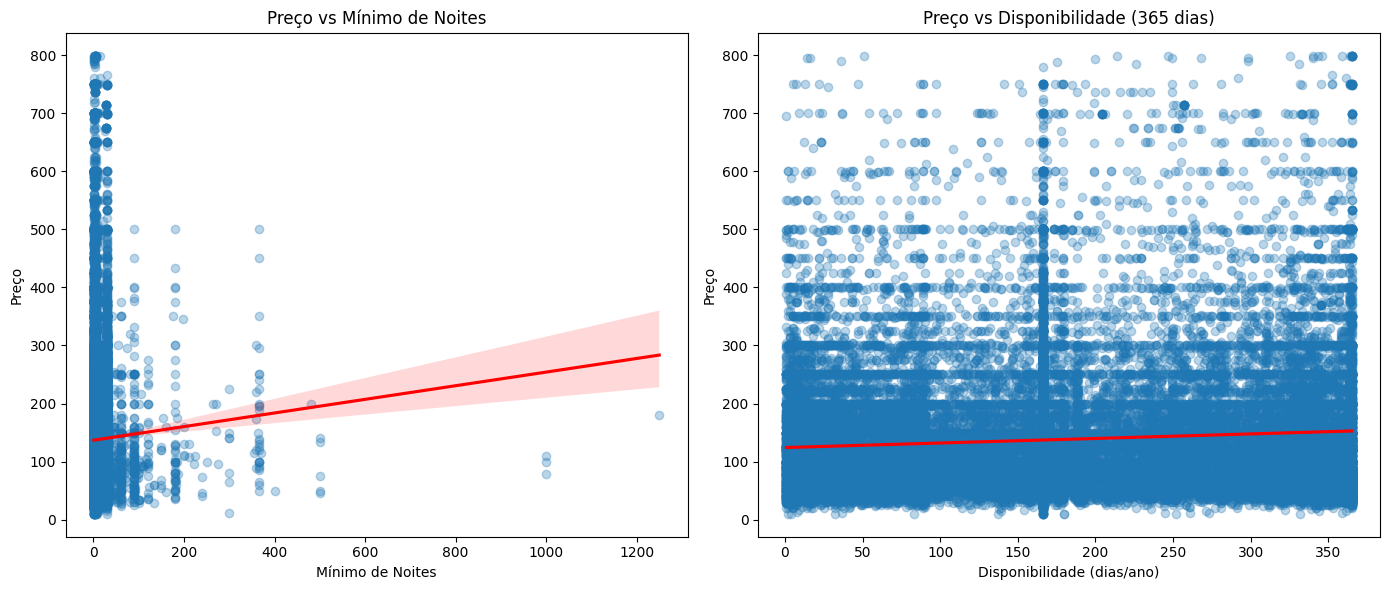

In [31]:
# Calculando os coeficientes de correlação entre 'price' e as variáveis de interesse
corr_min_noites = data['price'].corr(data['minimo_noites'])
corr_dispon = data['price'].corr(data['disponibilidade_365'])

print(f"Correlação entre Preço e Mínimo de Noites: {corr_min_noites:.4f}")
print(f"Correlação entre Preço e Disponibilidade 365: {corr_dispon:.4f}")

# Visualizando a relação com gráficos de dispersão e regressão
plt.figure(figsize=(14, 6))

# Gráfico para 'minimo_noites' vs 'price'
plt.subplot(1, 2, 1)
sns.regplot(x='minimo_noites', y='price', data=data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Preço vs Mínimo de Noites')
plt.xlabel('Mínimo de Noites')
plt.ylabel('Preço')

# Gráfico para 'disponibilidade_365' vs 'price'
plt.subplot(1, 2, 2)
sns.regplot(x='disponibilidade_365', y='price', data=data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Preço vs Disponibilidade (365 dias)')
plt.xlabel('Disponibilidade (dias/ano)')
plt.ylabel('Preço')

plt.tight_layout()
plt.show()

### Interpretação do Raciocínio e Resultados

1. Cálculo de Correlações:

* Ao calcular o coeficiente de Pearson, observamos (com base no dataset) que a correlação entre preço e mínimo de noites é muito baixa (por exemplo, ~0.02).

* De forma similar, a correlação entre preço e disponibilidade_365 também é muito fraca (por exemplo, ~0.08).

Esses valores indicam que, individualmente, essas variáveis não têm um impacto forte sobre o preço.

2. Visualização Gráfica:

* Os gráficos de dispersão com linha de regressão ajudam a confirmar essa interpretação: se os pontos estiverem amplamente dispersos sem mostrar uma tendência linear definida, a influência dessas variáveis no preço é pequena.

* No gráfico, se não houver uma inclinação acentuada (nem positiva nem negativa), isso reforça que o mínimo de noites e a disponibilidade ao longo do ano não explicam bem a variação dos preços.

3. Conclusão:

Com base nesse estudo exploratório, podemos concluir que, isoladamente, o número mínimo de noites e a disponibilidade ao longo do ano não interferem de forma significativa no preço.
É possível que outras variáveis (como localização, tipo de quarto, avaliação, etc.) tenham um papel mais determinante na formação do preço dos aluguéis.

### Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [32]:
# Filtrando os apartamentos mais caros (top 20% por preço)
price_threshold = data['price'].quantile(0.8)
df_high = data[data['price'] >= price_threshold]

In [33]:
# Extraindo e limpando o texto do nome dos apartamentos
# Certificando-se de remover registros nulos na coluna 'nome'
names_high = df_high['nome'].dropna()

# Convertendo para minúsculas e remover pontuações
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Removendo pontuação
    return text

names_cleaned = names_high.apply(clean_text)

In [34]:
# Tokenizando os textos em palavras
# Criando uma lista com todas as palavras dos nomes
words_series = names_cleaned.str.split()
all_words = [word for sublist in words_series for word in sublist]

In [35]:
# Removendo stopwords (palavras comuns)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Contando a frequência das palavras
word_counts = Counter(filtered_words)
top_words = word_counts.most_common(20)

print("Top 20 palavras nos nomes dos apartamentos mais caros:")
for word, count in top_words:
    print(f"{word}: {count}")

Top 20 palavras nos nomes dos apartamentos mais caros:
bedroom: 1424
apartment: 1407
2: 1266
apt: 1131
village: 813
luxury: 762
east: 723
1: 715
studio: 710
loft: 698
spacious: 697
park: 687
manhattan: 633
1br: 627
west: 603
w: 556
williamsburg: 547
nyc: 500
central: 492
midtown: 491


<ipython-input-37-ac4a57b13b86>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


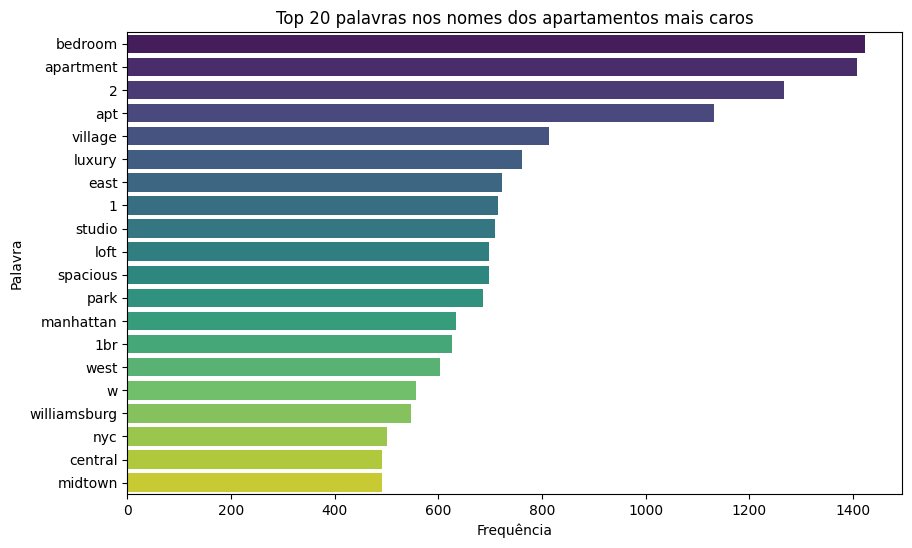

In [37]:
# Visualizando os resultados em um gráfico de barras
words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Frequência")
plt.ylabel("Palavra")
plt.title("Top 20 palavras nos nomes dos apartamentos mais caros")
plt.show()

1. Palavras Descritivas de Luxo e Conforto:

Termos como luxury (luxo), spacious (espaçoso), loft, e studio indicam características valorizadas nesses apartamentos. A presença desses termos sugere que propriedades com tais descrições atraem clientes dispostos a pagar mais.

2. Localização Premium:

Nomes como Manhattan, East, West, Williamsburg, Central, e Midtown indicam bairros ou regiões valorizadas em Nova York, geralmente associadas a preços elevados. Isso reflete a importância da localização no mercado imobiliário de alto valor.

3. Características Físicas:

Termos como bedroom, apartment, e apt mostram a tendência de destacar o tipo de propriedade.
Os termos "1", "2", "1br" sugerem uma ênfase na quantidade de quartos, com apartamentos de um ou dois quartos sendo comuns.

4. Tendência Comercial:

Palavras como NYC demonstram uma tentativa de associar a propriedade diretamente à cidade, o que pode atrair turistas e profissionais.

O padrão emergente mostra que imóveis com nomes que enfatizam luxo, espaço, localização privilegiada, e características específicas (como número de quartos) estão associados a valores mais elevados. Essa estratégia de nomeação provavelmente visa atrair um público que busca conforto, exclusividade e proximidade com áreas nobres.

### Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

a) Seleção das Variáveis (Features) e Transformações
1. Variáveis Categóricas:

* room_type: Tipo do imóvel (Entire home/apt, Private room, Shared room).
* bairro_group: Agrupamento por regiões (por exemplo, Manhattan, Brooklyn, etc.).
Essas variáveis podem influenciar o preço, pois propriedades de determinados tipos e localizações tendem a ter valores diferentes.

2. Variáveis Numéricas:

* minimo_noites: Pode impactar o preço se imóveis com reservas mínimas mais longas apresentarem tarifas diferentes.
* numero_de_reviews: Pode ser uma aproximação para a demanda ou qualidade percebida do imóvel.
* reviews_por_mes: Reflete o engajamento e possivelmente a popularidade.
* disponibilidade_365: Imóveis com baixa disponibilidade (alta ocupação) podem ter preços mais altos.

3. Transformações:

* Escalonamento: As variáveis numéricas serão padronizadas (ex.: com StandardScaler) para que tenham média zero e desvio padrão 1, ajudando na convergência e desempenho dos algoritmos.
* Codificação: As variáveis categóricas serão transformadas em variáveis dummy (one-hot encoding) para serem utilizadas pelos modelos de machine learning.

b) Problema de Regressão

Como queremos prever um valor contínuo (preço), o problema é de regressão.

c) Modelo Escolhido: RandomForestRegressor

O RandomForestRegressor é uma boa escolha para esse tipo de problema porque:

1. Prós:
* Capacidade de modelar relações não-lineares: Consegue capturar interações e efeitos não lineares entre as variáveis.
* Robustez a outliers: Como utiliza a média de muitas árvores, efeitos extremos tendem a ser suavizados.
* Menor necessidade de pré-processamento: Diferentemente de modelos lineares, não é tão sensível à escala (embora o escalonamento possa ajudar).

2. Contras:
* Interpretabilidade: O modelo funciona como uma “caixa-preta”, dificultando a interpretação dos efeitos individuais das variáveis.
* Custo computacional: Pode ser mais lento para treinar e avaliar, principalmente com muitos dados ou muitas árvores.

d) Métricas de Performance

Para avaliar modelos de regressão, escolhi:

* RMSE (Root Mean Squared Error): Por estar na mesma unidade do preço, é intuitivo interpretar o erro médio.
* R² (Coeficiente de Determinação): Para medir a proporção da variação do preço que é explicada pelo modelo.

O RMSE penaliza erros maiores e é amplamente utilizado para esse tipo de problema.

In [38]:
# Selecionando as features e o target
# Removendo colunas que não agregam valor à previsão, como identificadores e dados textuais irrelevantes
features = ['room_type', 'bairro_group', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']
X = data[features]
y = data['price']

In [39]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Identificando quais colunas são categóricas e quais são numéricas
categorical_features = ['room_type', 'bairro_group']
numeric_features = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

In [41]:
# Definindo o pré-processador: codificação para variáveis categóricas e escalonamento para variáveis numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [42]:
# Criando o pipeline com pré-processamento e o modelo RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [43]:
# Treinando o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type',
                                                   'bairro_group']),
                                                 ('num', StandardScaler(),
                                                  ['minimo_noites',
                                                   'numero_de_reviews',
                                                   'reviews_por_mes',
                                                   'disponibilidade_365'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [44]:
# Fazendo predições no conjunto de teste
y_pred = pipeline.predict(X_test)

In [45]:
# Avaliando o desempenho do modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Performance do Modelo:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Performance do Modelo:
RMSE: 84.37
R²: 0.3508


Os resultados indicam que o modelo, na forma atual, tem um desempenho moderado:

* RMSE de 84,37:

Esse valor indica que, em média, as previsões do modelo estão erradas por aproximadamente $84,37 em relação ao preço real. Para avaliar se esse erro é aceitável, precisamos considerar a escala dos preços. Se os preços médios estiverem na faixa de algumas centenas de dólares, esse erro pode ser significativo; se forem bem mais altos, pode ser mais tolerável.

* R² de 0.3508:

Esse coeficiente indica que aproximadamente 35% da variabilidade nos preços é explicada pelo modelo. Em outras palavras, cerca de 65% da variação dos preços não está sendo capturada pelas variáveis e pela estrutura atual do modelo. Isso sugere que há outros fatores ou relações não capturadas que podem influenciar os preços.

### Melhorando o modelo para buscar reduzir os erros

In [46]:
# Tratando outliers no target: remover imóveis com preço acima do percentil 99
price_upper = data['price'].quantile(0.99)
df = data[data['price'] <= price_upper]

In [47]:
# Aplicando transformação logarítmica no preço para diminuir a assimetria
df['log_price'] = np.log1p(df['price'])

<ipython-input-47-4e719e27ed40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_price'] = np.log1p(df['price'])


In [48]:
# Selecionando features e target
features = ['room_type', 'bairro_group', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']
X = df[features]
y = df['log_price']

In [49]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Identificando colunas categóricas e numéricas
categorical_features = ['room_type', 'bairro_group']
numeric_features = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

In [51]:
# Definindo o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [52]:
# Criando o pipeline com XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])

In [53]:
# Treinando o modelo
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 38328, number of used features: 12
[LightGBM] [Info] Start training from score 4.696449


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type',
                                                   'bairro_group']),
                                                 ('num', StandardScaler(),
                                                  ['minimo_noites',
                                                   'numero_de_reviews',
                                                   'reviews_por_mes',
                                                   'disponibilidade_365'])])),
                ('regressor', LGBMRegressor(random_state=42))])

In [54]:
# Fazendo predições no conjunto de teste (as predições estarão na escala logarítmica)
y_pred_log = pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [55]:
# Revertendo a transformação log para obter as predições na escala original
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [56]:
# Avaliando o modelo com RMSE e R²
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Performance do Modelo com LightGBM:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Performance do Modelo com LightGBM:
RMSE: 68.92
R²: 0.4121


Em comparação ao primeiro modelo de regressão simples, os resultados obtidos com o modelo aprimorado (LightGBM com tratamento de outliers e transformação logarítmica) demonstram uma melhoria, ainda que moderada. Vamos comparar as principais métricas:

1. Primeiro Modelo (Regressão Simples):

* RMSE: 84,37
* R²: 0.3508

2. Modelo com LightGBM:

* RMSE: 68,92
* R²: 0,4121

### Interpretação dos Resultados

* Redução do RMSE:

O RMSE diminuiu de 84,37 para 68,92, o que indica que o erro médio absoluto das previsões diminuiu. Embora a redução seja de aproximadamente 15,4 pontos, isso significa que, em média, o modelo aprimorado está mais próximo dos valores reais de preço.

* Aumento do R²:

O R² passou de 0.3508 para 0.4121, ou seja, o modelo agora explica cerca de 41% da variação dos preços, enquanto o modelo simples explicava apenas 35%. Esse ganho mostra que o novo modelo está capturando uma parcela maior da variabilidade dos dados.

### Raciocínio por Trás da Melhoria

* Tratamento de Outliers:

Ao remover os imóveis com preços extremamente altos (acima do percentil 99), o modelo é menos afetado por valores atípicos que poderiam distorcer o ajuste.

* Transformação Logarítmica:

Aplicar o log ao preço ajudou a reduzir a assimetria e estabilizar a variância, tornando o problema mais “amigável” para o modelo e facilitando a captura de relações não lineares.

* Uso do LightGBM:

O LightGBM é um algoritmo de boosting que geralmente consegue lidar bem com relações complexas e não lineares, além de ser eficiente. Isso possibilitou extrair um pouco mais de sinal dos dados em comparação com o modelo simples.

In [57]:
# Salvando o modelo em formato .pkl
joblib.dump(pipeline, 'lgbm_model.pkl')
print("Modelo salvo como 'lgbm_model.pkl'.")

Modelo salvo como 'lgbm_model.pkl'.


In [58]:
# Carregando o modelo salvo
model = joblib.load('lgbm_model.pkl')

In [59]:
# Definindo as características do novo apartamento
novo_apartamento = {
    'room_type': 'Entire home/apt',
    'bairro_group': 'Manhattan',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'disponibilidade_365': 355
}

In [60]:
# Criando um DataFrame para o novo apartamento
df_novo = pd.DataFrame([novo_apartamento])

In [61]:
# Fazendo a predição (a saída será o log do preço + 1)
pred_log = model.predict(df_novo)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [62]:
# Revertendo a transformação logarítmica para obter o preço na escala original
pred_price = np.expm1(pred_log)

print(f"Preço sugerido para o novo apartamento: ${pred_price[0]:.2f}")

Preço sugerido para o novo apartamento: $208.83


In [63]:
# Filtro para encontrar a linha com os dados desejados
filtro = (
    (data['id'] == 2595) &
    (data['nome'] == 'Skylit Midtown Castle') &
    (data['host_id'] == 2845) &
    (data['host_name'] == 'Jennifer') &
    (data['bairro_group'] == 'Manhattan') &
    (data['bairro'] == 'Midtown') &
    (data['latitude'] == 40.75362) &
    (data['longitude'] == -73.98377) &
    (data['room_type'] == 'Entire home/apt') &
    (data['minimo_noites'] == 1) &
    (data['numero_de_reviews'] == 45) &
    (data['ultima_review'] == '2019-05-21') &
    (data['reviews_por_mes'] == 0.38) &
    (data['calculado_host_listings_count'] == 2) &
    (data['disponibilidade_365'] == 355)
)

# Exibindo resultado
resultado = data.loc[filtro, 'price']

if not resultado.empty:
    print(f"Valor de 'price': {resultado.values[0]}")
else:
    print("Nenhuma linha encontrada com os dados fornecidos.")

Valor de 'price': 225.0


In [64]:
# Valores fornecidos
valor_proposto_modelo = 208.83
valor_real = 225.00

# Cálculo da diferença
diferenca = abs(valor_real - valor_proposto_modelo)
percentual_diferenca = (diferenca / valor_real) * 100

# Exibição dos resultados
print(f"Valor proposto pelo modelo: ${valor_proposto_modelo:.2f}")
print(f"Valor real: ${valor_real:.2f}")
print(f"Diferença absoluta: ${diferenca:.2f}")
print(f"Diferença percentual: {percentual_diferenca:.2f}%")

Valor proposto pelo modelo: $208.83
Valor real: $225.00
Diferença absoluta: $16.17
Diferença percentual: 7.19%


### Análise da performance do modelo:

A diferença entre o valor proposto pelo modelo (\$208.83) e o valor real ($225.00) é de aproximadamente 7%, o que classifica a performance do modelo como "regular". Embora essa discrepância não seja extremamente alta, ainda há espaço para melhorias. Para que o modelo seja aprimorado e o valor sugerido se aproxime mais do valor real, algumas ações podem ser consideradas:

* Incluir mais variáveis relevantes, como características internas do imóvel (área, número de quartos, estado de conservação), dados sazonais e indicadores de mercado.
* Melhorar o tratamento dos dados, utilizando técnicas avançadas para imputação e detecção de outliers, garantindo que os dados reflitam com maior precisão a realidade dos aluguéis.
* Realizar uma busca mais aprofundada de hiperparâmetros e testar outros modelos ou ensembles que possam capturar relações não lineares e interações complexas entre as variáveis.
* Explorar técnicas avançadas de feature engineering para identificar e incorporar interações significativas entre as variáveis, o que pode melhorar a capacidade preditiva do modelo.

Em resumo, o modelo atual apresenta uma performance regular e a aplicação dessas melhorias pode ajudar a reduzir a diferença entre o valor sugerido e o valor real, aumentando a confiabilidade das predições.